In [2]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

In [3]:
data_csv = pd.read_csv("data\\labeled_data.csv")
data_csv.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
tweets_list = data_csv['tweet'].tolist()
labels_list = data_csv['class'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [5]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [6]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [7]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [8]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [9]:
embedding_vecor_length = 200

model_embed = Sequential()
model_embed.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],
                          input_shape=(max_wordNum,),trainable=False, name='Embedding'))
model_embed.compile(optimizer='RMSprop', loss='mean_squared_error')
#print (model_embed.summary())
X_train_embedded = model_embed.predict(X_train)
X_valid_embedded = model_embed.predict(X_valid)

In [10]:
#embedding_vecor_length = 200
latent_dim = 100

inputs = Input(shape=(max_wordNum,embedding_vecor_length))

#embedding = Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],trainable=True)(inputs)

encoded = LSTM(latent_dim)(inputs) #(embedding)

decoded1 = RepeatVector(max_wordNum)(encoded)
decoded2 = LSTM(embedding_vecor_length, return_sequences=True)(decoded1)
#decoded3 = LSTM(max_wordNum, return_sequences=False)(decoded2)
#decoded3 = TimeDistributed(Dense(1))(decoded2) 
#decoded3 = Reshape((max_wordNum,))(decoded3)

sequence_autoencoder = Model(inputs, decoded2)

encoder = Model(inputs, encoded)

sequence_autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')
#sequence_autoencoder.compile(loss='binary_crossentropy', optimizer='adam')


print (sequence_autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 52, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 200)           240800    
Total params: 361,200
Trainable params: 361,200
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

autoencoder_train = sequence_autoencoder.fit(X_train_embedded, X_train_embedded,
                            batch_size=100,
                            epochs=20,
                            validation_data=(X_valid_embedded, X_valid_embedded)
                            ,callbacks=callbacks
                            )

Train on 12397 samples, validate on 6190 samples
Epoch 1/20
12397/12397 [==============================] - 106s 9ms/step - loss: 0.0491 - val_loss: 0.0479
Epoch 2/20
12397/12397 [==============================] - 99s 8ms/step - loss: 0.0479 - val_loss: 0.0464
Epoch 3/20
12397/12397 [==============================] - 99s 8ms/step - loss: 0.0468 - val_loss: 0.0455
Epoch 4/20
12397/12397 [==============================] - 98s 8ms/step - loss: 0.0459 - val_loss: 0.0450
Epoch 5/20
12397/12397 [==============================] - 103s 8ms/step - loss: 0.0455 - val_loss: 0.0448
Epoch 6/20
12397/12397 [==============================] - 80s 6ms/step - loss: 0.0452 - val_loss: 0.0449
Epoch 7/20
12397/12397 [==============================] - 65s 5ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 8/20
12397/12397 [==============================] - 60s 5ms/step - loss: 0.0448 - val_loss: 0.0444
Epoch 9/20
12397/12397 [==============================] - 64s 5ms/step - loss: 0.0446 - val_loss: 0.0440
Epoc

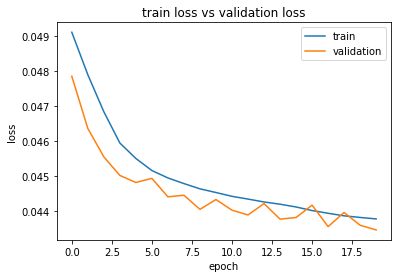

In [12]:
plt.figure()
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [13]:
X_test_embedded = model_embed.predict(X_test)
score = sequence_autoencoder.evaluate(X_test_embedded, X_test_embedded, verbose=0)
print('Test loss:', score)

Test loss: 0.04321942929349229


In [14]:
X_train_encoded = encoder.predict(X_train_embedded)
X_valid_encoded = encoder.predict(X_valid_embedded)

class_count = Y.shape[1]

model = Sequential()
model.add(Dense(20,activation='relu',name='Hidden_Layer_1', input_shape=(latent_dim,)))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train_encoded, y_train, 
                    validation_data=[X_valid_encoded,y_valid],
                    epochs=100, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 12397 samples, validate on 6190 samples
Epoch 1/100
12397/12397 [==============================] - 2s 147us/step - loss: 0.7107 - acc: 0.7855 - val_loss: 0.5361 - val_acc: 0.8234
Epoch 2/100
12397/12397 [==============================] - 1s 49us/step - loss: 0.5167 - acc: 0.8224 - val_loss: 0.4997 - val_acc: 0.8268
Epoch 3/100
12397/12397 [==============================] - 1s 45us/step - loss: 0.4984 - acc: 0.8265 - val_loss: 0.4920 - val_acc: 0.8286
Epoch 4/100
12397/12397 [==============================] - 1s 50us/step - loss: 0.4923 - acc: 0.8287 - val_loss: 0.4885 - val_acc: 0.8307
Epoch 5/100
12397/12397 [==============================] - 1s 51us/step - loss: 0.4887 - acc: 0.8301 - val_loss: 0.4851 - val_acc: 0.8351
Epoch 6/100
12397/12397 [==============================] - 1s 47us/step - loss: 0.4869 - acc: 0.8305 - val_loss: 0.4842 - val_acc: 0.8331
Epoch 7/100
12397/12397 [==============================] - 1s 50us/step - loss: 0.4849 - acc: 0.8309 - val_loss: 0.4821 - 

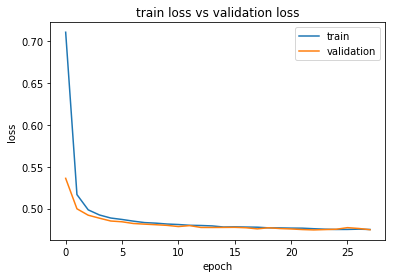

In [16]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [17]:
X_test_encoded = encoder.predict(X_test_embedded)
score = model.evaluate(X_test_encoded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.45700653344681375
Test accuracy: 0.8465138799994896
